In [1]:
# Notebook Imports
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
import string
from collections import defaultdict
from sklearn.metrics import r2_score
import statsmodels.api as sm
import plotly.graph_objects as go
%matplotlib inline

conn = psycopg2.connect(dbname="illinois_gambling")

def query(query):
    return pd.read_sql(query, conn)

## Purpose

In this notebook I use hierarchical linear models to evaluate the relationship between video gambling revenue and casino revenue, race, sector employment, and whether a municipality is classified as urban or rural. 

### Introduction

Video gambling was legalized by the state of Illinois in 2009, with the first machines activated in September of 2012. Since then the number of towns that have installed video gambling machines has increased every year.
> **Note:** While data for 2020 has been reported by the [Illinois Gaming Board](https://www.igb.illinois.gov/) the data requires further clarification from the Illinois Gaming Board before it can be confidently analyzed due to enforced shutdowns of video gambling to mitigate transmission of COVID19. Because of this, 2020 data  is largely excluded from this analysis and excluded entirely from the models develops in this notebook. 

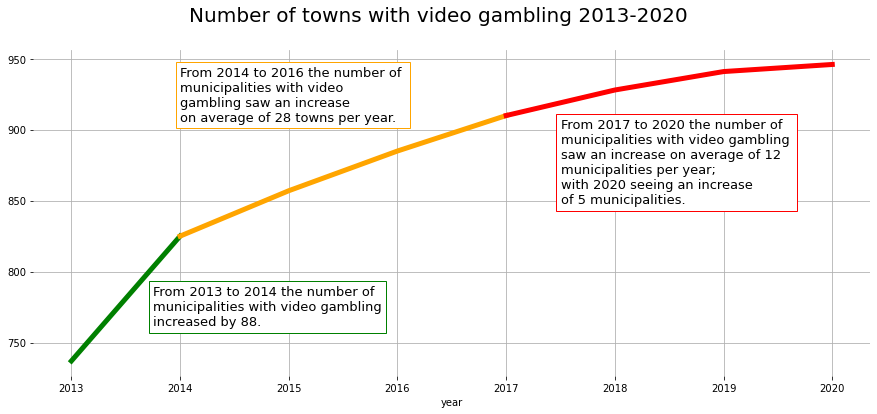

In [2]:
### Visualization Code
q = '''SELECT DISTINCT CAST(date_part('year', video_gambling.date) AS INT) as year, 
              count(DISTINCT municipality.name) as num_of_towns
       FROM municipality
       INNER JOIN video_gambling
       ON municipality.name = video_gambling.municipality
       GROUP BY date_part('year', video_gambling.date);'''

query_results = query(q).set_index('year')
fig, ax = plt.subplots()
query_results.loc[:2014].num_of_towns.plot(ax=ax, figsize=(15,6), linewidth=5, linestyle='-', c='green')
query_results.loc[2014:2017].num_of_towns.plot(ax=ax, figsize=(15,6), linewidth=5, linestyle='-', c='orange')
query_results.loc[2017:].num_of_towns.plot(ax=ax, figsize=(15,6), linewidth=5, linestyle='-', c='red')
# axes[0].set_yticks(query_results.num_of_towns)
fig.suptitle('Number of towns with video gambling 2013-2020', fontsize=20)
ax.grid()

ax.set_frame_on(False)

first_annotation = ax.text(2013.75, 762, 
f'''From 2013 to 2014 the number of\nmunicipalities \
with video gambling\nincreased by\
 {int(query_results.loc[[2013,2014]].num_of_towns.diff().iloc[1])}.''', dict(size=13))
first_annotation.set_bbox(dict(facecolor='white', edgecolor='green'))

second_annotation = ax.text(2014, 906, f'''\
From 2014 to 2016 the number of 
municipalities with video 
gambling saw an increase\non average of \
{int(round(query_results.loc[2014:2017].num_of_towns.diff().mean()))} \
towns per year.''', dict(size=13))
second_annotation.set_bbox(dict(facecolor='white', edgecolor='orange'))

third_annotation = ax.text(2017.5, 848, f'''\
From 2017 to 2020 the number of
municipalities with video gambling 
saw an increase on average of \
{int(round(query_results.loc[2017:].num_of_towns.diff().mean()))} 
municipalities per year; 
with 2020 seeing an increase 
of {int(round(query_results.loc[2017:].num_of_towns.diff().loc[2020]))} municipalities.''', dict(size=13))
third_annotation.set_bbox(dict(facecolor='white', edgecolor='red'))


Prior to the legalization of video gambling, if an Illinois residents had wanted to gamble their only option was to travel to a municipality that had a casino.

In [182]:
# Visualization Code 

q = '''SELECT DISTINCT municipality, latitude, longitude
        FROM casino;'''

towns_with_casinos = query(q)

fig = go.Figure()

fig.add_trace(go.Scattergeo(
        lat=towns_with_casinos.latitude,
        lon=towns_with_casinos.longitude,
        mode='markers',
        marker = {'size': 20,
                 'color': 'red'},
        text=towns_with_casinos.municipality,
    ))


fig.update_layout(
    title='Municipalities with Casinos',
    autosize=True,
    hovermode='closest',
    showlegend=False,
    geo = go.layout.Geo(
        resolution = 50,
        scope = 'usa',
        showframe = False,
        showcoastlines = True,
        projection_scale=4.5,
        center = dict(
            lat=39.7,
            lon=-88.7)
    ),
)

fig.show()

Since legalization of video gambling, this has changed immensely. 

In [181]:
# Visualization Code
q = '''SELECT name, latitude, longitude, terminal_count
        FROM (
        SELECT SUM(terminal_count) as terminal_count, municipality AS name
        FROM video_gambling
        WHERE DATE_PART('year', video_gambling.date) = 2019
        AND DATE_PART('month', video_gambling.date) = 12
        GROUP BY municipality) subquery
        INNER JOIN municipality
        USING(name);
        '''


def bin_colors(count):
    colors = ['#fa0505','#ff5100','#ff8c00','#ffbf00','#fff700','#ffffff']
    bins = [200,400,600,800,1000,1200]
    for idx in range(len(bins)):
        if count <= bins[idx]:
            return colors[idx]
        
results = query(q)

results['colors'] = results.terminal_count.apply(bin_colors)

fig = go.Figure()

for idx, row in results.iterrows():

    fig.add_trace(go.Scattergeo(
            lat=[row.latitude],
            lon=[row.longitude],
            mode='markers',
            marker = {'size': 5,
                     'opacity':.5,
                     'color': row.colors},
            text='<b>' + row['name'] + '</b></br>' + 'Terminal Count: ' + str(row.terminal_count),
        ))


fig.update_layout(
    title='Municipalities with Video Gambling 2019',
    autosize=True,
    hovermode='closest',
    showlegend=False,
    geo = go.layout.Geo(
        resolution = 50,
        scope = 'usa',
        showframe = False,
        showcoastlines = True,
        projection_scale=4.5,
        center = dict(
            lat=39.7,
            lon=-88.7)
    ),
)

fig.show()

In [83]:
# Queries
q = '''SELECT DISTINCT town.name
        FROM municipality town
        LEFT JOIN casino ON casino.municipality = town.name
        WHERE casino.municipality IS NULL'''
towns_without_casinos = query(q)

q = '''SELECT * from demographics_lookup'''

lookup = query(q)

demographic_variables = ('demo.' + '"' + lookup['variable'] + '"').to_list()

q = f'''SELECT {", ".join(demographic_variables)},
              video.terminal_count,
              video.date,
              video.state_share as video_state_share,
              video.municipality_share as video_local_share,
              video.amount_played,
              town.name,
              town.nearest_casino,
              casino.adjusted_gross_receipt,
              casino.state_share as casino_state_share,
              casino.local_share as casino_local_share
      FROM demographics demo
      JOIN municipality town
          ON demo.municipality = town.name
          AND demo.geo_id = town.geo_id
     JOIN casino
          ON casino.address = town.nearest_casino
     JOIN video_gambling video
          ON video.municipality = town.name
     WHERE date_part('year', video.date) = demo.year
     AND casino.date = video.date
     ORDER BY date;'''

df = query(q)

In [86]:
df.date

0        2013-01-01
1        2013-01-01
2        2013-01-01
3        2013-01-01
4        2013-01-01
            ...    
777435   2018-12-01
777436   2018-12-01
777437   2018-12-01
777438   2018-12-01
777439   2018-12-01
Name: date, Length: 777440, dtype: datetime64[ns]